In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter

from random import randint

from IPython.display import Image
from IPython.core.display import Image, display
from numpy import random
import numpy as np
import src.model as vae

from sklearn.manifold import TSNE

C:\Users\shira\AppData\Local\Temp\ipykernel_15420\607147439.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
bs = 32
Train = False
Resume = False
game = 'qbert'
if game == 'breakout':
    vae_type = 'vae' # vae, betavae, betatcvae
    clustering = 'stdb' # hir, sc, hdb, stdb
    reduce_model = 'umap' # umap, tsne, none
    num_component = 2
    n_neighbors = 30 # UMAP parameter default 15, 30 is better
    min_dist = 0.1 # UMAP parameter default 0.1
    ep1 = [1.2, 0.3, 0.1, 0.15, 0.1, 0.7] # A2C, ApeX, DQN, ES, GA, Rainbow
    ep2 = 15
    min_samples = 8
    num_clusters = 4
    cluser_size = 150
else:
    vae_type = 'vae' # vae, betavae, betatcvae
    clustering = 'stdb' # hir, sc, hdb, stdb
    reduce_model = 'umap' # umap, tsne, none
    num_component = 2
    n_neighbors = 30 # UMAP parameter default 15, 30 is better
    min_dist = 0.1 # UMAP parameter default 0.1
    ep1 = [0.8, 0.8, 0.8, 0.8, 0.8, 0.8] # A2C, ApeX, DQN, ES, GA, Rainbow
    ep2 = 5
    min_samples = 8
    num_clusters = 4
    cluser_size = 150
random.seed(1)
torch.manual_seed(1)
writer = SummaryWriter('./runs/' + vae_type + '_' + game)

In [5]:
s_epochs = 0
d_epochs = 60
epochs = s_epochs + d_epochs

In [6]:
# Load Data for Training VAE
dataset = datasets.ImageFolder(root='./torch_images_label/' + game, transform=transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), 
]))
train_size = int(0.8 * len(dataset.imgs))
test_size = len(dataset.imgs) - train_size
train_dataset, eval_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=bs, shuffle=False)
len(dataset.imgs), len(dataloader),len(dataloader.dataset)

(15006, 376, 12004)

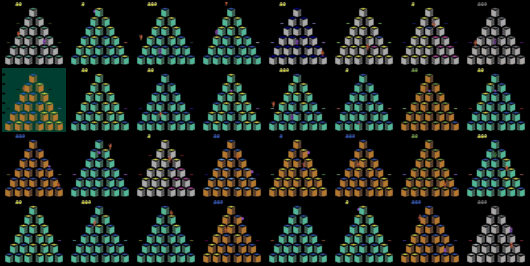

In [7]:
# Fixed input for debugging
fixed_x, _ = next(iter(dataloader))
save_image(fixed_x, './saved_images/'+ game + '/input_image.png')

Image('./saved_images/'+ game + '/input_image.png')

In [8]:
image_channels = fixed_x.size(1)

In [9]:
if vae_type == 'vae':
    model = vae.VAE(image_channels=image_channels).to(device)
elif vae_type == 'betavae':
    model = vae.BetaVAE(image_channels=image_channels, ep=s_epochs, dl_size=len(dataloader)).to(device)
elif vae_type == 'miwae':
    model = vae.MIWAE(image_channels=image_channels).to(device)
elif vae_type == 'betatcvae':
    model = vae.BetaTCVAE(image_channels=image_channels, dataset_size=len(dataloader.dataset)).to(device)

if not(Train and not(Resume)) :
    checkpoint = torch.load('./saved_model/' + vae_type + '_'+ game + '.torch', map_location='cpu')
    model.load_state_dict(checkpoint)

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

if Train:
    early_stopping = vae.EarlyStopping(patience=3, verbose=True, path='./saved_model/' + vae_type + '_'+ game + '.torch')
    for epoch in range(s_epochs, epochs):
        loss_ave = 0
        recons_ave = 0
        kld_ave = 0
        for idx, (images, _) in enumerate(dataloader):
            recon_images, mu, logvar = model(images)
            loss, recons, kld = model.loss_fn(recon_images, images, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if idx % 100 == 0:
                to_print = "Epoch[{}/{}] Step: {} Loss: {:.3f} Recon: {:.3f} KLD: {:.5f}".format(epoch+1, 
                                        epochs, idx, loss.item()/bs, recons.item()/bs, kld.item()/bs)
                print(to_print)
            loss_ave = (idx * loss_ave + (loss.item()/bs)) / (idx +1)
            recons_ave = (idx * recons_ave + (recons.item()/bs)) / (idx +1)
            kld_ave = (idx * kld_ave + (kld.item()/bs)) / (idx +1)
        
        eval_loss = vae.eval_model(model, device, eval_dataloader)
        print('Epoch[{}/{}] Loss AVE: {:.3f} Eval Loss: {:.3f} Recon AVE: {:.3f} KLD AVE: {:.5f}'
              .format(epoch+1, epochs, loss_ave, eval_loss, recons_ave, kld_ave))
        writer.add_scalars('loss', {'train loss' : loss_ave, 'eval loss' : eval_loss}, epoch+1)
        writer.add_scalars('loss detail', {'train loss' : loss_ave, 'recons' : recons_ave, 'kld' : kld_ave}, epoch+1)
        early_stopping(loss_ave, model)
        #if early_stopping.early_stop:
        #    break 

    torch.save(model.state_dict(), './saved_model/' + vae_type + '_'+ game + '.torch')
    writer.close()

In [11]:
def compare(x):
    z, _, _ = model.encode(x)
    recon_x = model.decode(z)
    #recon_x, _, _ = vae(x)
    return x, recon_x, z

tensor([[ 0.0702, -0.3508,  0.1409, -0.1107, -0.2497, -0.1011, -0.1552, -0.2526,
         -0.2990,  0.2645,  0.1143, -0.1541, -0.6221,  0.4176,  1.1273,  1.2667,
         -0.0641,  0.8694, -0.0055, -0.2618, -0.3466,  0.0559,  0.5864,  0.1965,
         -0.7431,  0.5509, -1.0127, -0.1276,  0.0289, -0.0096, -0.5986,  0.1211]],
       grad_fn=<AddBackward0>)


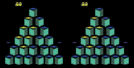

In [12]:
# sample = torch.randn(bs, 1024)
# compare_x = vae.decoder(sample)

# fixed_x, _ = next(iter(dataloader))
# fixed_x = fixed_x[:8]
fixed_x = dataset[randint(1, 100)][0].unsqueeze(0)
#fixed_x = dataset[0][0].unsqueeze(0)
x, recon_x, code_z = compare(fixed_x)
print(code_z)
save_image(torch.cat([x, recon_x]).data.cpu(), './saved_images/'+ game + '/input_recon_image_' + vae_type + '.png')
display(Image('./saved_images/'+ game  + '/input_recon_image_' + vae_type + '.png', width=300, unconfined=True))

In [13]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    

# Load Data for Training VAE
test_dataset = ImageFolderWithPaths(root='./torch_images_label/' + game, transform=transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), 
]))

In [14]:
# dataloader without shuffle for testing
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs)

def get_frame_id(path_tuple):
    frame_id_list = []
    for path in path_tuple:
        frame_id_list.append(int(path.split('_')[-1][:-4]))
    return torch.as_tensor(frame_id_list)

In [15]:
z_list = []
label_list = []
frame_list = []
for idx, (images, labels, path) in enumerate(test_dataloader):
        z_batch, _, _ = model.encode(images)
        z_list.append(z_batch)
        label_list.append(labels)
        frame_list.append(get_frame_id(path))
        z_all = torch.cat(z_list, dim=0)
        label_all = torch.cat(label_list, dim=0)
        frame_all = torch.cat(frame_list, dim=0)


In [16]:
from sklearn.decomposition import PCA
import pandas as pd
import umap

c:\Users\shira\anaconda3\envs\XAI\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\shira\anaconda3\envs\XAI\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\shira\anaconda3\envs\XAI\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWa

In [17]:
# Add label colunm to df
def add_colunm_to_df(df, columname, add_data, add_name):
    add_df = pd.DataFrame(list(add_data.detach().numpy()))
    df = pd.concat([df,add_df],axis = 1,join='inner', ignore_index=True)
    df = df.loc[:,~df.columns.duplicated()]
    columname.append(add_name)
    df.columns = columname
    return df 

In [18]:
z_all_np = z_all.detach().numpy()
if reduce_model == "umap": 
    reducer = umap.UMAP(n_components=num_component, n_neighbors= n_neighbors, min_dist = min_dist, random_state=42)
    embedding = reducer.fit_transform(z_all_np)
elif reduce_model == "tsne":
    reducer = TSNE(n_components=num_component, random_state = 42, perplexity = 30, n_iter = 1000)
    embedding = reducer.fit_transform(z_all_np)
elif reduce_model == "none":
    reducer = umap.UMAP(n_components=num_component, n_neighbors= n_neighbors, min_dist = min_dist, random_state=42)
    embedding = reducer.fit_transform(z_all_np)
    #embedding = z_all_np
    #num_component = 32

columname = ['component'+ str(i+1) for i in range(num_component)]
principalDf = pd.DataFrame(data = embedding[:,0:num_component], columns = columname)
principalDf = add_colunm_to_df(principalDf, columname, label_all, "label")
principalDf = add_colunm_to_df(principalDf, columname, frame_all, "frame")

columname = ['component'+ str(i+1) for i in range(z_all_np.shape[1])]
z_df =pd.DataFrame(data = z_all_np, columns = columname)
z_df = add_colunm_to_df(z_df, columname, label_all, "label")
z_df = add_colunm_to_df(z_df, columname, frame_all, "frame")

# Add label colunm to df

#label = pd.DataFrame(list(label_all.detach().numpy()))
#principalDf = pd.concat([principalDf,label],axis = 1,join='inner', ignore_index=True)
#principalDf = principalDf.loc[:,~principalDf.columns.duplicated()]
#columname.append("label")
#principalDf.columns = columname 

# Add frame colunm to df
#frame = pd.DataFrame(list(frame_all.detach().numpy()))
#principalDf = pd.concat([principalDf,frame],axis = 1,join='inner', ignore_index=True)
#principalDf = principalDf.loc[:,~principalDf.columns.duplicated()]
#columname.append("frame")
#principalDf.columns = columname 

<Figure size 640x480 with 0 Axes>

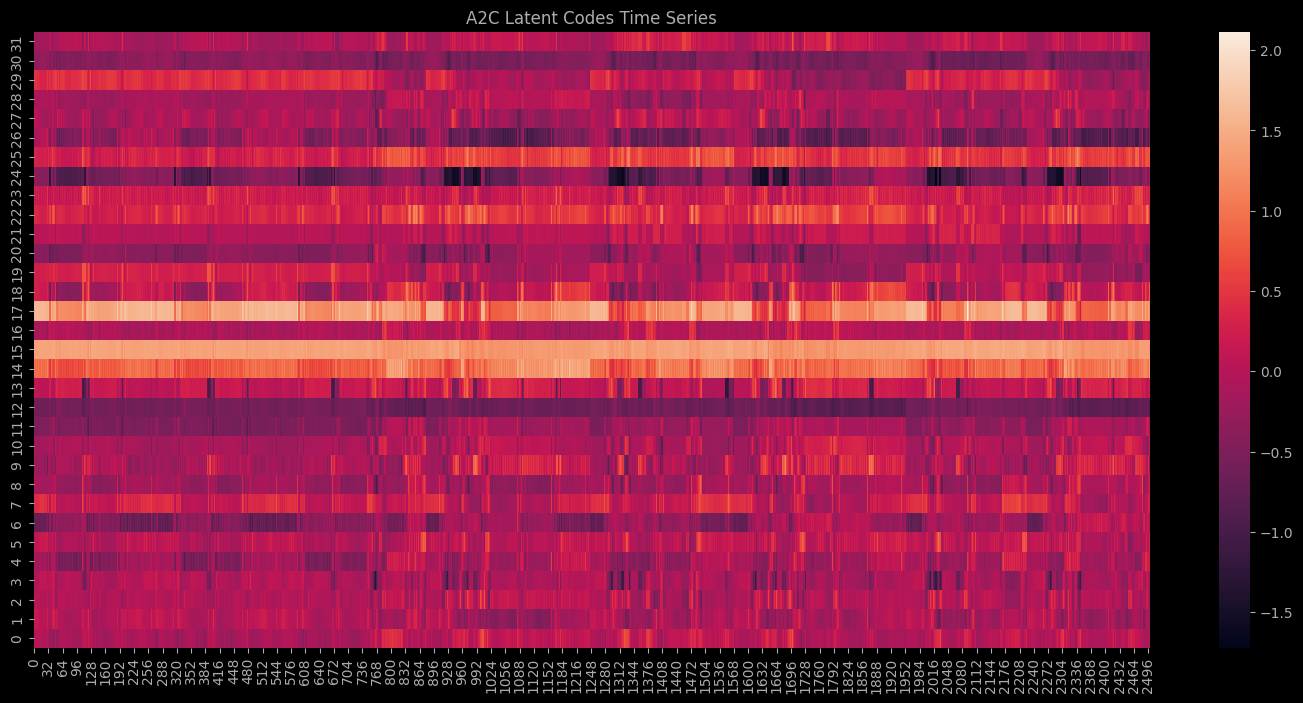

<Figure size 640x480 with 0 Axes>

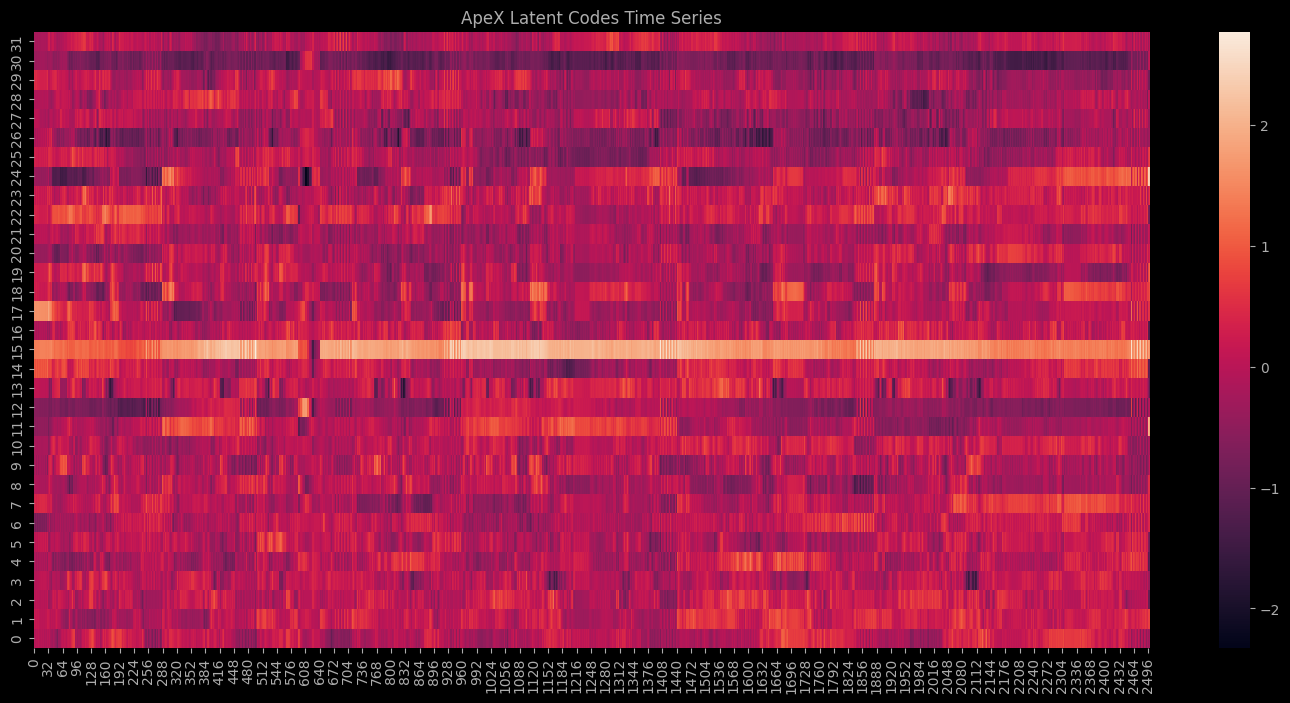

<Figure size 640x480 with 0 Axes>

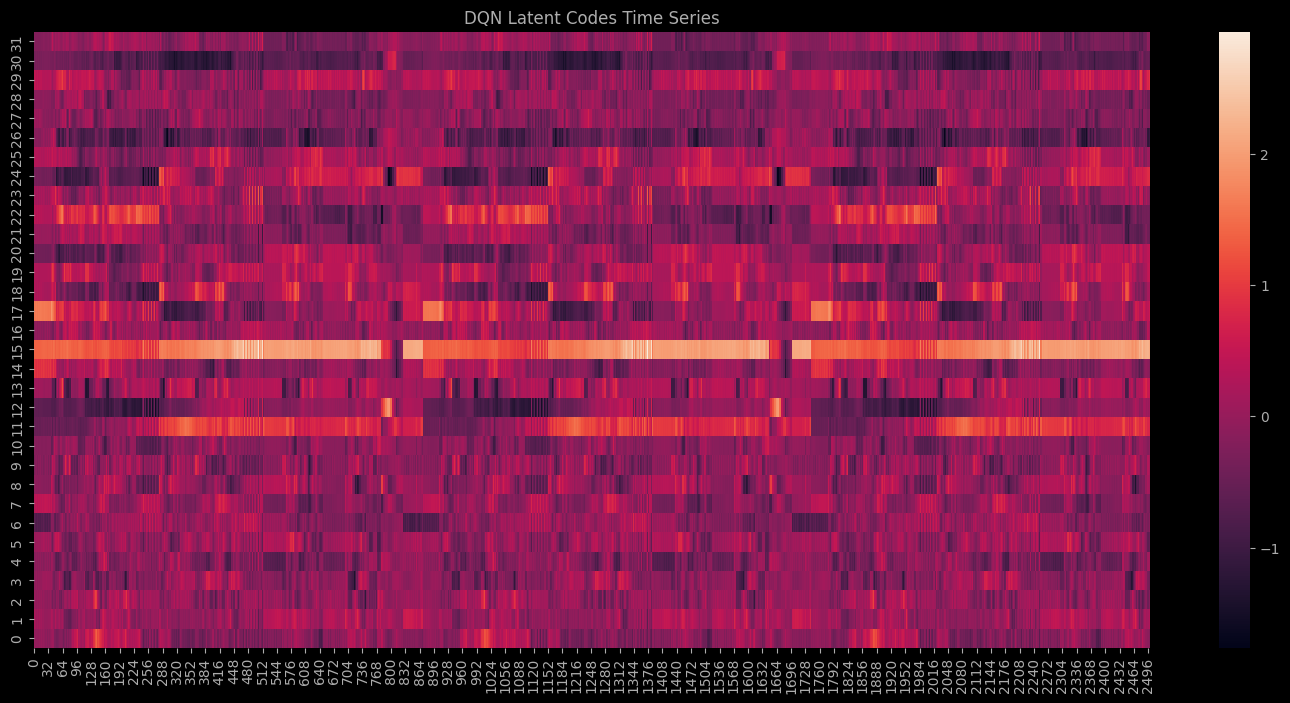

<Figure size 640x480 with 0 Axes>

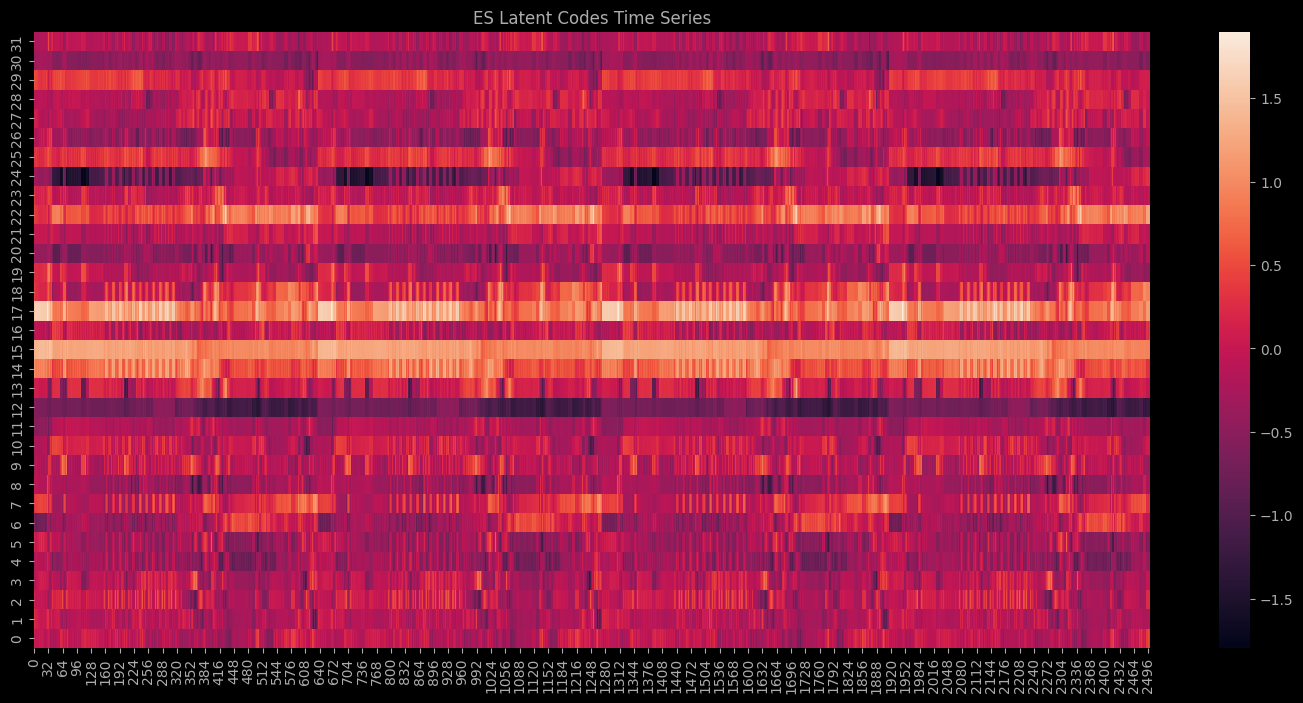

<Figure size 640x480 with 0 Axes>

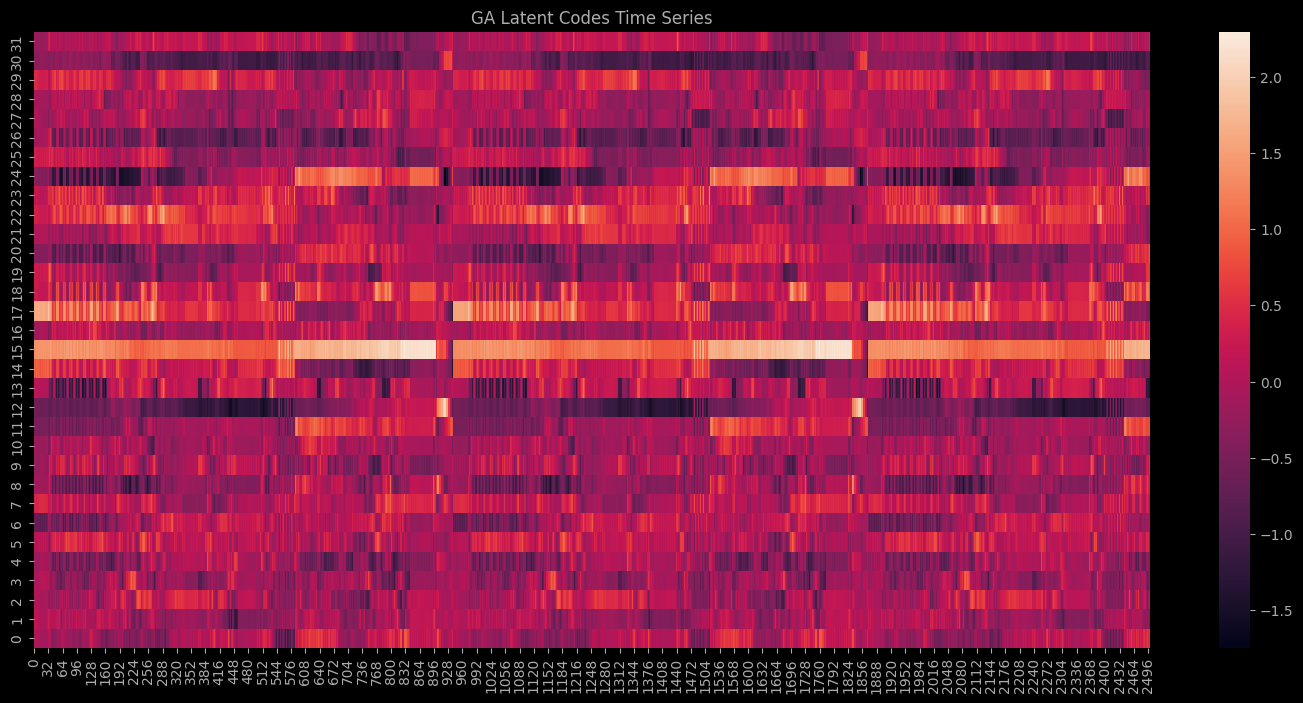

<Figure size 640x480 with 0 Axes>

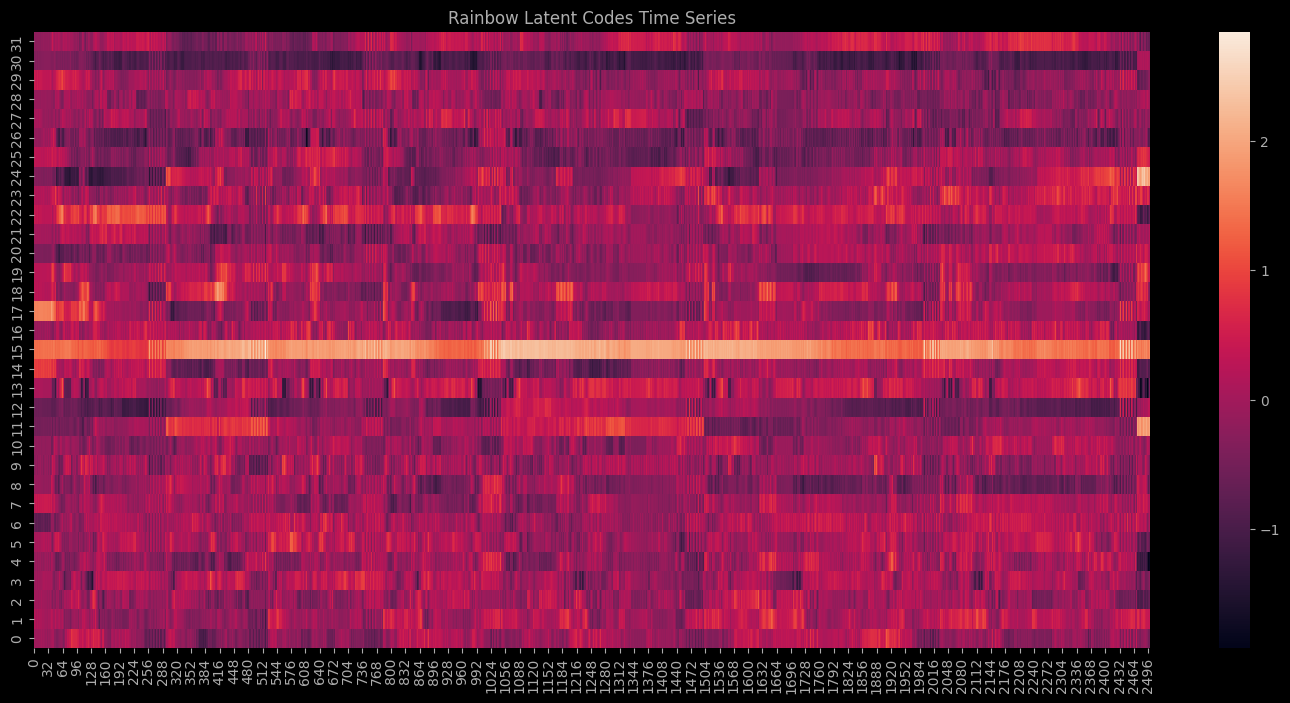

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
label_name = ['A2C','ApeX','DQN','ES','GA','Rainbow']
colors = ['#B4E1FF','#FBB7C0','#82667F','#CFF27E', "#FCA311", "#3498db"]
columname = ['component'+ str(i+1) for i in range(z_all_np.shape[1])]

for idx in range(len(label_name)):
    plt.figure(facecolor='#000000')
    fig, ax =plt.subplots(figsize=(18,8))
    df_by_agent_idx = z_df.loc[:,'label'] == idx
    df_by_agent = z_df[df_by_agent_idx]
    df_by_agent = df_by_agent.sort_values(by=['frame'])
    g=sns.heatmap(np.transpose(df_by_agent[columname].to_numpy()))
    cbar = g.collections[0].colorbar
    cbar.ax.tick_params(labelcolor='#adadad', color='#adadad')
    #ratio=0.2
    ax.set_xlim(0, 2500)  
    ax.set_ylim(0, 32)  
    x_left, x_right = ax.get_xlim()
    y_low, y_high = ax.get_ylim() 
    #ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
    fig.set_facecolor('#000000')
    ax.set_facecolor('#000000')
    ax.tick_params(colors='#adadad')
    ax.xaxis.label.set_color('#adadad')
    ax.yaxis.label.set_color('#adadad')
    ax.set_title(label_name[idx] + ' Latent Codes Time Series', color='#adadad')
    plt.show()

For DBSCAN Tuning 

<Figure size 640x480 with 0 Axes>

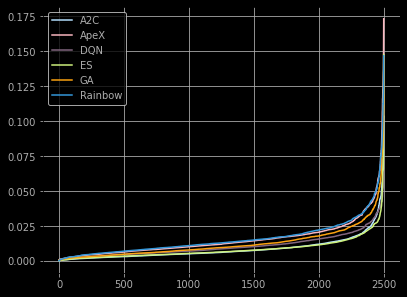

In [20]:
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
label_name = ['A2C','ApeX','DQN','ES','GA','Rainbow']
colors = ['#B4E1FF','#FBB7C0','#82667F','#CFF27E', "#FCA311", "#3498db"]
columname = ['component'+ str(i+1) for i in range(num_component)]

plt.figure(facecolor='#000000')
fig, ax =plt.subplots(dpi=72)
for idx in range(len(label_name)):
    df_by_agent_idx = z_df.loc[:,'label'] == idx
    df_by_agent = z_df[df_by_agent_idx]
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(df_by_agent[columname])
    distances, indices = nbrs.kneighbors(df_by_agent[columname])
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances, label=idx, color=colors[idx])
plt.grid()
fig.set_facecolor('#000000')
ax.set_facecolor('#000000')
plt.legend(label_name, facecolor='#000000', labelcolor='#adadad')
ax.tick_params(colors='#adadad')
ax.xaxis.label.set_color('#adadad')
ax.yaxis.label.set_color('#adadad')

In [21]:
import math
math.log(len(dataset.imgs)/len(label_name))

7.824445930877619

Visualize Tragectories with UMAP

<Figure size 640x480 with 0 Axes>

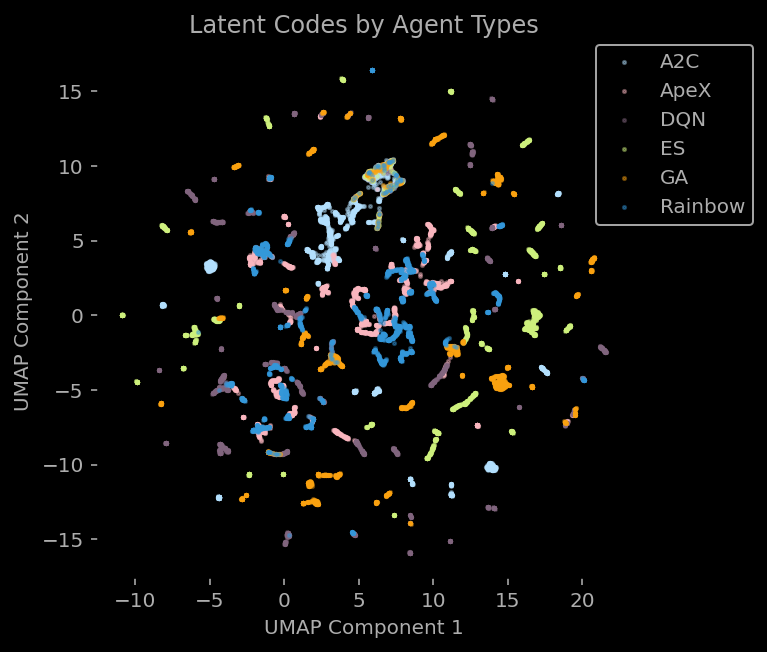

In [22]:
magnify = 2
plt.figure(facecolor='#000000')
fig, ax =plt.subplots(dpi=72*magnify)
label_name = ['A2C','ApeX','DQN','ES','GA','Rainbow']
colors = ['#B4E1FF','#FBB7C0','#82667F','#CFF27E', "#FCA311", "#3498db"]

for idx, color in enumerate(colors):
    filter = principalDf["label"] == idx
    plotdata=principalDf.where(filter)
    ax.scatter(x=plotdata["component1"], y=plotdata["component2"], c=color, label=label_name[idx], alpha=0.4, marker='.',  s = 10)
    
ax.legend(facecolor='#000000', labelcolor='#adadad', bbox_to_anchor=(1.25,1.02))
fig.set_facecolor('#000000')
ax.set_facecolor('#000000')
ax.tick_params(colors='#adadad')
ax.set_title('Latent Codes by Agent Types', color='#adadad')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.xaxis.label.set_color('#adadad')
ax.yaxis.label.set_color('#adadad')
ratio = 1.0
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

plt.savefig('./saved_images/' + game + '/LatentAgent_' + vae_type + '.png')


Apply Clustering

In [23]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
import hdbscan
from st_dbscan import ST_DBSCAN
pd.options.mode.chained_assignment = None

cls = pd.DataFrame(np.nan, index=z_df.index, columns=['cls'])
columname = ['component'+ str(i+1) for i in range(z_all_np.shape[1])]
columname.append("label")
columname.append("frame")
#cls = pd.DataFrame(clus_result)
z_df = pd.concat([z_df,cls],axis = 1,join='inner', ignore_index=True)
z_df = z_df.loc[:,~z_df.columns.duplicated()]
#columname = z_df.columns
columname.append("cls")
z_df.columns = columname


if clustering == 'hir':
    for idx in range(len(colors)):
        df_by_agent_idx = z_df.loc[:,'label'] == idx
        df_by_agent = z_df[df_by_agent_idx]
        columname = ['component'+ str(i+1) for i in range(z_all_np.shape[1])]
        hir_clus_model = AgglomerativeClustering(n_clusters = num_clusters, affinity = 'euclidean', linkage = 'ward').fit(df_by_agent[columname].to_numpy())
        z_df["cls"].iloc[z_df["label"] == idx] = num_clusters*idx + hir_clus_model.labels_
        print(set(hir_clus_model.labels_))
    #hir_clus_model = AgglomerativeClustering(n_clusters = num_clusters, affinity = 'euclidean', linkage = 'ward')
    #principalDf["cls"] = hir_clus_model.fit_predict(z_all_np)

elif clustering == 'sc':
    for idx in range(len(colors)):
        df_by_agent_idx = z_df.loc[:,'label'] == idx
        df_by_agent = z_df[df_by_agent_idx]
        columname = ['component'+ str(i+1) for i in range(z_all_np.shape[1])]
        sc = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors', eigen_solver="arpack").fit(df_by_agent[columname].to_numpy())
        z_df["cls"].iloc[z_df["label"] == idx] = num_clusters*idx + sc.labels_
        #print(set(sc.labels_))
        #sc = SpectralClustering(n_clusters=num_clusters).fit(z_all_np)
        #sc = SpectralClustering(n_clusters=num_clusters).fit(embedding[:,0:2])
        #principalDf["cls"] = sc.labels_

elif clustering == 'hdb':
    num_clusters_by_agent = []
    offset = 0
    for idx in range(len(colors)):
        df_by_agent_idx = z_df.loc[:,'label'] == idx
        df_by_agent = z_df[df_by_agent_idx]
        columname = ['component'+ str(i+1) for i in range(z_all_np.shape[1])]
        clusterer = hdbscan.HDBSCAN(min_cluster_size=cluser_size).fit(df_by_agent[columname].to_numpy())
        num_clusters = len(set(clusterer.labels_))
        print(set(clusterer.labels_+ 1))
        num_clusters_by_agent.append(num_clusters)
        if idx == 0:
            z_df["cls"].iloc[z_df["label"] == idx] = (clusterer.labels_ + 1)
            offset = num_clusters_by_agent[idx]
        else:
            z_df["cls"].iloc[z_df["label"] == idx] = offset + (clusterer.labels_ + 1)
            offset += num_clusters_by_agent[idx]
            
elif clustering == 'stdb':
        num_clusters_by_agent = []
        offset = 0
        for idx in range(len(colors)):
            df_by_agent_idx = z_df.loc[:,'label'] == idx
            df_by_agent = z_df[df_by_agent_idx]
            columname = ['frame']
            component_name = ['component'+ str(i+1) for i in range(z_all_np.shape[1])]
            columname = columname + component_name
            st_data = df_by_agent.loc[:, columname].values
            # eps1 : space, eps 2: time, eps1 from kink of nearest neighbor plot, min sample is from log(samples) = 9.6 original paper
            # eps1 2D 0.05, 4D 0.15
            st_dbscan = ST_DBSCAN(eps1 = ep1[idx], eps2 = ep2, min_samples = min_samples).fit(st_data) 
            num_clusters = len(set(st_dbscan.labels))
            print(set(st_dbscan.labels + 1))
            num_clusters_by_agent.append(num_clusters)
            if idx == 0:
                z_df["cls"].iloc[z_df["label"] == idx] = (st_dbscan.labels + 1)
                offset = num_clusters_by_agent[idx]
            else:
                z_df["cls"].iloc[z_df["label"] == idx] = offset + (st_dbscan.labels + 1)
                offset += num_clusters_by_agent[idx]

z_df.head(-200)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22

,component1,component2,component3,component4,component5,component6,component7,component8,component9,component10,...,component26,component27,component28,component29,component30,component31,component32,label,frame,cls
0,-0.063470,0.178112,-0.006784,-0.062416,-0.123926,0.056064,-0.722645,0.388352,-0.071362,-0.181765,...,0.357023,-0.109402,0.061716,-0.113795,0.484373,-0.347806,-0.205638,0,0,1.0
1,0.005141,0.199382,0.046587,-0.075538,-0.206759,0.060732,-0.639572,0.355276,-0.091339,-0.311547,...,0.301421,-0.056903,0.050684,-0.096315,0.496344,-0.359167,-0.208252,0,1,1.0
2,0.078021,0.167258,0.055966,-0.022582,-0.258432,0.179055,-0.629852,0.381195,-0.134644,-0.323929,...,0.240742,-0.012251,-0.018802,-0.059665,0.447497,-0.333924,-0.185106,0,10,1.0
3,-0.259293,-0.115071,-0.089568,-0.038399,-0.448904,-0.180644,-0.380519,0.013555,-0.272309,-0.066923,...,0.308701,-0.557754,-0.152378,-0.261863,0.433368,-0.455810,0.030207,0,100,2.0
4,0.544500,-0.501506,0.704656,-0.045152,-0.398609,-0.223657,-0.157510,-0.570733,-0.279306,0.428302,...,0.585556,-0.665429,-0.099524,-0.027756,0.081035,-0.641415,0.237529,0,1000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14801,0.219306,0.387447,-0.148597,-0.583029,-0.139099,0.492798,-0.065443,-0.389199,0.003497,-0.004998,...,0.168604,-0.326200,-0.033045,-0.058359,0.570281,-0.722347,0.142121,5,814,285.0
14802,0.221776,0.411299,-0.119156,-0.576606,-0.153130,0.527878,-0.002314,-0.383908,-0.041061,-0.061392,...,0.137250,-0.274645,-0.032025,-0.055073,0.588745,-0.733201,0.146046,5,815,285.0
14803,0.239838,0.394858,-0.076037,-0.543871,-0.231628,0.482799,0.096941,-0.394469,-0.084597,-0.175429,...,0.131455,-0.158814,-0.143706,0.008865,0.632838,-0.751932,0.166883,5,816,285.0
14804,0.219292,0.400461,-0.012990,-0.549825,-0.326166,0.471638,0.163827,-0.377658,-0.091444,-0.269796,...,0.122162,-0.009312,-0.227357,-0.031718,0.630987,-0.803245,0.209749,5,817,285.0


In [24]:
cls = pd.DataFrame(list(z_df["cls"]))
columname = columname = ['component'+ str(i+1) for i in range(num_component)]
columname.append("label")
columname.append("frame")
columname.append("cls")
principalDf = pd.concat([principalDf,cls],axis = 1,join='inner', ignore_index=True)
principalDf = principalDf.loc[:,~principalDf.columns.duplicated()]
principalDf.columns = columname 
principalDf.head()

,component1,component2,label,frame,cls
0,7.357129,8.527124,0,0,1.0
1,6.805166,8.230469,0,1,1.0
2,6.705153,8.483927,0,10,1.0
3,13.930219,-9.994887,0,100,2.0
4,3.645989,3.684099,0,1000,0.0


In [25]:
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))

def hex_to_rgb(hex):
    hex = hex.lstrip('#')
    return tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))

In [26]:
def get_agentID_count(num_clusters_by_agent, agent_id, count):
    count += 1
    if count-1 == num_clusters_by_agent[agent_id]:
        count = 1
        agent_id +=1
    else:
        pass
    return agent_id, count

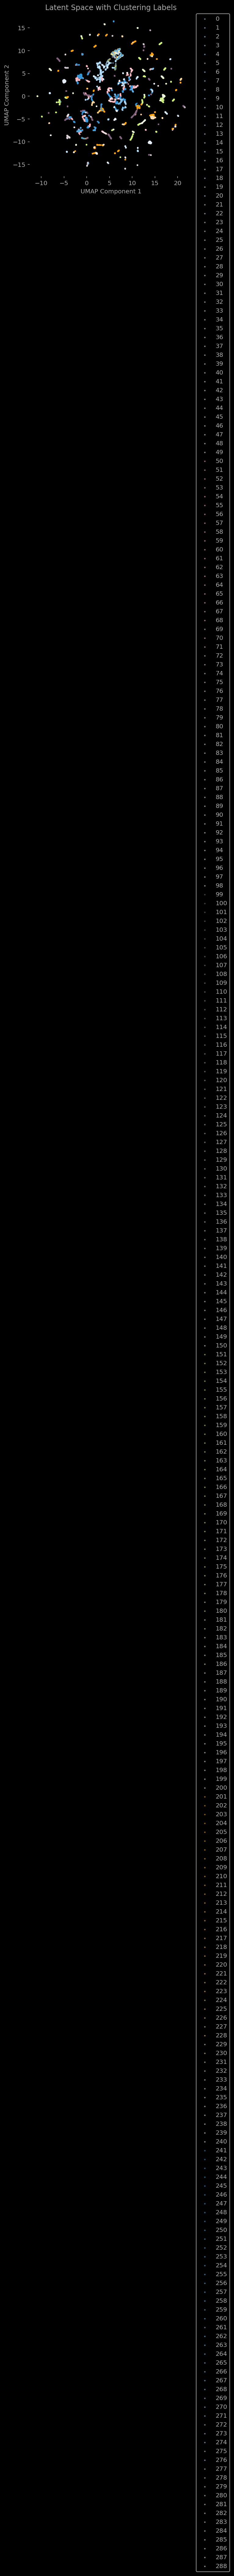

In [27]:

import seaborn as sns

magnify = 2
fig, ax =plt.subplots(dpi=72*magnify)
cluster_labels = np.unique(principalDf["cls"])  
n_clusters = cluster_labels.shape[0]   
count = 0 
agent_id = 0

#colors = sns.color_palette("husl", n_clusters)
agent_colors = ['#B4E1FF','#FBB7C0','#82667F','#CFF27E', "#FCA311", "#3498db"]
for i in range(n_clusters):
    filter = principalDf["cls"] == i 
    plotdata=principalDf.where(filter)

    if clustering == 'hdb' or clustering == 'stdb':   
        agent_id, count = get_agentID_count(num_clusters_by_agent, agent_id, count)
        #print('agentID: ' + str(agent_id) + ', count: ' + str(count) + ', Color: ' + str(agent_colors[agent_id]))
        del colors
        colors = sns.light_palette(agent_colors[agent_id],  num_clusters_by_agent[agent_id], reverse=True)
        #print(colors[count-1])
        ax.scatter(x=plotdata["component1"], y=plotdata["component2"], 
                   c=rgb_to_hex(colors[count-1]), label=i, marker='.', alpha=0.4, s = 10)
        
    else:  
        agent_id = i // num_clusters
        colors = sns.light_palette(agent_colors[agent_id],  num_clusters, reverse=True)
        print('A agentID: ' + str(agent_id) + ', count: ' + str(i % num_clusters) + ', Color: ' + str(agent_colors[agent_id]))
        ax.scatter(x=plotdata["component1"], y=plotdata["component2"], 
                   c=rgb_to_hex(colors[i % num_clusters]), label=i, marker='.', alpha=0.4, s = 10)
       
fig.set_facecolor('#000000')
ax.legend(facecolor='#000000', labelcolor='#adadad', bbox_to_anchor=(1.25,1.02))
ax.set_facecolor('#000000')
ax.tick_params(colors='#adadad')
ax.set_title('Latent Space with Clustering Labels', color='#adadad')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.xaxis.label.set_color('#adadad')
ax.yaxis.label.set_color('#adadad')
ratio = 1.0
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

plt.savefig('./saved_images/' + game + '/LatentClusters_' + vae_type + '.png')

In [28]:
z_code_by_cls_tensor = torch.empty(size=(n_clusters, z_all_np.shape[1]))

for i in range(n_clusters):
    filter = z_df["cls"] == i
    z_code_by_cls = z_df.where(filter)
    #z_code_by_cls_tensor[i] = torch.tensor(z_code_by_cls.mean()[:-1].values).float()
    z_code_by_cls_tensor[i] = torch.tensor(z_code_by_cls.median()[:-3].values).float()

    recon_image = model.decode(z_code_by_cls_tensor[i].reshape(1,-1))
    save_image(recon_image.data.cpu(), './cls_images/' + game + '/cls_image_' + str(i) + '_' + clustering + '.png')
    #display(Image('./cls_images/' + game + '/cls_image_' + str(i) + '_' + clustering + '.png', width=300, unconfined=True))

In [29]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
z_code_by_cls_np = z_code_by_cls_tensor.detach().numpy()
#z_cls_pca = pca.transform(z_code_by_cls_np)
z_cls_pca = reducer.transform(z_code_by_cls_np)

def getImage(path, zoom):
   return OffsetImage(plt.imread(path, format="png"), zoom=zoom)

def find_nearest(array, value):
   array = np.asarray(array)
   idx = (np.abs(array-value)).argmin()
   new_array = np.delete(array, idx)
   return array[idx], new_array

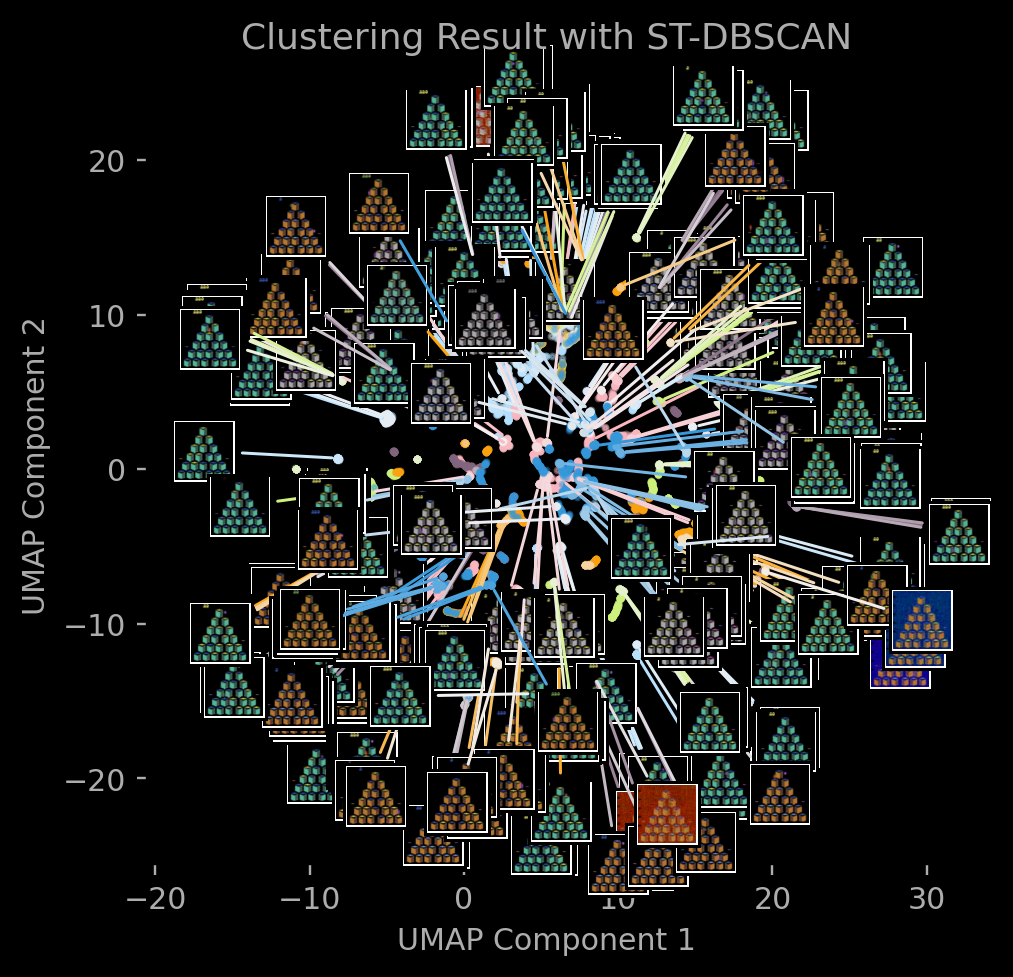

In [30]:
import math

magnify = 3
fig, ax =plt.subplots(dpi=72*magnify)
cluster_labels = np.unique(principalDf["cls"])  
n_clusters = cluster_labels.shape[0]    
count = 0 
agent_id = 0

#colors = sns.color_palette("husl", n_clusters)
agent_colors = ['#B4E1FF','#FBB7C0','#82667F','#CFF27E', "#FCA311", "#3498db"]

for i in range(n_clusters):
   filter = principalDf["cls"] == i
   plotdata=principalDf.where(filter)

   if clustering == 'hdb' or clustering == 'stdb':   
      agent_id, count = get_agentID_count(num_clusters_by_agent, agent_id, count)
      #print('agentID: ' + str(agent_id) + ', count: ' + str(count))
      colors = sns.light_palette(agent_colors[agent_id],  num_clusters_by_agent[agent_id], reverse=True)
      ax.scatter(x=plotdata["component1"], y=plotdata["component2"], 
                  c=rgb_to_hex(colors[count-1]), label=i, marker='.', alpha=0.4, s = 10)
        
   else:  
        agent_id = i // num_clusters
        colors = sns.light_palette(agent_colors[agent_id],  num_clusters, reverse=True)
        ax.scatter(x=plotdata["component1"], y=plotdata["component2"], 
                   c=rgb_to_hex(colors[i % num_clusters]), label=i, marker='.', alpha=0.4, s = 10)
        
   #agent_id = i // num_clusters
   #colors = sns.light_palette(agent_colors[agent_id],  num_clusters, reverse=True)
   #ax.scatter(x=plotdata["component1"], y=plotdata["component2"], c=rgb_to_hex(colors[i % num_clusters]), marker='.', alpha=0.3, s = 2, label=str(i))

ax.set_facecolor('#000000')
ax.tick_params(colors='#adadad')
if clustering == 'hdb': 
    title = 'Clustering Result with HDBSCAN'
elif clustering == 'sc': 
   title = 'Clustering Result with Spectral Clustering'
elif clustering == 'hir': 
   title = 'Clustering Result with Agglomerative Clustering'
elif clustering == 'stdb': 
   title = 'Clustering Result with ST-DBSCAN'

ax.set_title(title, color='#adadad')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.xaxis.label.set_color('#adadad')
ax.yaxis.label.set_color('#adadad')
ratio = 1.0
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
xy_center = ((x_right+x_left)/2, (y_low+y_high)/2)
slot = np.linspace(-3.14, 3.14, num=n_clusters+10)
radius = 50
count = 0 
agent_id = 0

for i in range(n_clusters):
   path = './cls_images/' + game + '/cls_image_' + str(i) + '_' + clustering + '.png'
   xy = (z_cls_pca[i][0],  z_cls_pca[i][1])
   anot_rad = math.atan2(xy[1]-xy_center[1], xy[0]-xy_center[0])
   assigned_rad, slot = find_nearest(slot, anot_rad)
   
   if clustering == 'hdb' or clustering == 'stdb':   
      agent_id, count = get_agentID_count(num_clusters_by_agent, agent_id, count)
      #print('agentID: ' + str(agent_id) + ', count: ' + str(count))
      colors = sns.light_palette(agent_colors[agent_id],  num_clusters_by_agent[agent_id], reverse=True)
      ab = AnnotationBbox(getImage(path, zoom=0.3), xy, frameon=True,
                  xybox=(radius*math.cos(assigned_rad)+xy_center[0], radius*math.sin(assigned_rad)+xy_center[1]),
                  xycoords='data',
                  boxcoords="offset points",
                  pad=0.1,
                  arrowprops=dict(arrowstyle="-", color=rgb_to_hex(colors[count-1]))
                  )
        
   else:  
        agent_id = i // num_clusters
        colors = sns.light_palette(agent_colors[agent_id],  num_clusters, reverse=True)
        ab = AnnotationBbox(getImage(path, zoom=0.3), xy, frameon=True,
                  xybox=(radius*math.cos(assigned_rad)+xy_center[0], radius*math.sin(assigned_rad)+xy_center[1]),
                  xycoords='data',
                  boxcoords="offset points",
                  pad=0.1,
                  arrowprops=dict(arrowstyle="-", color=rgb_to_hex(colors[i % num_clusters]))
                  )
   

   ax.add_artist(ab)
fig.set_facecolor('#000000')
#ax.legend(facecolor='#000000', labelcolor='#adadad', bbox_to_anchor=(1.45,1.02))
offset=8
ax.set_xlim(x_left-offset, x_right+offset)  
ax.set_ylim(y_low-offset, y_high+offset)   
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

plt.savefig('./saved_images/' + game + '/LatentClusters_with_recon_images_' + clustering + '_' + vae_type + '.png')

In [31]:
def get_cls_sequence(agent_num, df, min_frame, max_frame):
    filter = df["label"] == int(agent_num)
    agent_data = df.where(filter).sort_values("frame")
    agent_data_np = np.asarray(agent_data["cls"][min_frame:max_frame])
    cls_seq = agent_data_np[~np.isnan(agent_data_np)]
    return cls_seq

# window analysis filtering
def get_most_frequent_cls(seq, window):
    max_cls_in_window = []
    for i in range(len(seq)- window + 1):
        lst = list(seq[i : i + window])
        max_cls_in_window.append(max(lst, key=lst.count))
    return np.array(max_cls_in_window).astype(int)


def get_minimum_sequence(seq):
    cls_diff_index = np.nonzero(np.diff(np.array(seq)))[0]
    return np.append(seq[cls_diff_index-1], seq[-1])



In [32]:
def transition_matrix(transitions, n):
    #n = 1+ max(transitions) #number of states

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M

#test:

#t = [1,1,2,6,8,5,5,7,8,8,1,1,4,5,5,0,0,0,1,1,4,4,5,1,3,3,4,5,4,1,1]
#m = transition_matrix(t)
#for row in m: print(' '.join('{0:.2f}'.format(x) for x in row))

arrow, umap graph

In [33]:
inference_frame_size = {
    "alien":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "amidar":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [718, 1609, 1625, 737, 769, 1773]},
    "assault":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "asterix":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [65, 1198, 574, 229, 2499, 1551]},
    "atrantis":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "battlezone":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "berzerk":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "bowling":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [214, 210, 210, 103, 102, 218]},
    "boxing":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [1779, 384, 1046, 2499, 2499, 416]},
    "breakout":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [698, 2499, 2499, 2499, 2499, 1475]},
    "chopper":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "fishing":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "freeway":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 48, 57, 105, 157, 108]},
    "icehockey":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "kungfumaster":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "montezuma":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "mspacman":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "pong":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "qbert":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [48, 287, 280, 636, 585, 295]},
    "seaquest":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "skiing":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "spaceinveders":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [669, 473, 828, 1292, 1654, 583]},
}
min_frames = inference_frame_size[game]["min_frames"]
max_frames = inference_frame_size[game]["max_frames"]

Get Initial Image

In [34]:
initial_x = dataset[0][0].unsqueeze(0)
z_initial, _, _ = model.encode(initial_x)
initial_recon_image = model.decode(z_initial.reshape(1,-1))
z_initial_pca = reducer.transform(z_initial.detach().numpy())
save_image(initial_recon_image.data.cpu(), './cls_images/' + game + '/initial.png')

In [35]:
#print(z_code_by_cls_tensor[i])
vector = []
for i in range(n_clusters):
    vector.append((z_code_by_cls_tensor[i]-z_initial)[0].cpu().detach().numpy())

from sklearn.decomposition import PCA

pca = PCA(n_components=1)

imageAxis = pca.fit_transform(vector)

print(imageAxis)

[[-1.09504092]
 [-1.29981526]
 [-1.21432598]
 [-1.00394736]
 [-0.98677333]
 [-1.09284122]
 [-1.30716361]
 [-1.15405921]
 [-1.19843757]
 [-1.03682762]
 [-1.16358981]
 [-1.11487334]
 [-1.07396431]
 [-1.04705991]
 [-1.15292536]
 [-1.213007  ]
 [-1.30312019]
 [-1.18131077]
 [-1.02858519]
 [-1.13758631]
 [-0.84940187]
 [-0.80058758]
 [-0.82381723]
 [-0.89460325]
 [-1.30677472]
 [-1.07920801]
 [-1.2983145 ]
 [-1.19508241]
 [-1.14886641]
 [-1.07391149]
 [-1.10202025]
 [-1.29548149]
 [-1.17796535]
 [-0.9246247 ]
 [-0.90328331]
 [-0.86248268]
 [-0.88304097]
 [-1.02436519]
 [-1.30312749]
 [-1.21981207]
 [-1.19830125]
 [-1.31230411]
 [-1.22133758]
 [-1.2070992 ]
 [-0.94231284]
 [-1.14045916]
 [-1.29847307]
 [-1.17639278]
 [-1.02170678]
 [-1.12917087]
 [ 0.68031027]
 [-1.30438762]
 [ 1.36065595]
 [-0.88334429]
 [ 1.48004263]
 [-0.9762584 ]
 [ 1.88103003]
 [-0.88384039]
 [ 1.79050274]
 [ 1.73430409]
 [ 1.8546557 ]
 [ 0.17314456]
 [ 0.11523797]
 [ 0.27311047]
 [ 0.35758309]
 [ 0.41270819]
 [ 0.63664

****** A2C ******
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1]
****** ApeX ******
[51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51.
 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 51. 86. 86. 86. 86. 86.
 86. 86. 86. 86. 86. 86. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91. 91.
 91. 91. 91. 91. 98. 98. 98. 98. 98. 98. 98. 98. 53. 53. 53. 53. 53. 53.
 53. 53. 55. 55. 55. 55. 55. 55. 55. 55. 55. 57. 57. 57. 57. 57. 57. 57.
 57. 57. 73. 73. 73. 73. 73. 73. 73. 73. 73. 73. 73. 73. 73. 73. 73. 73.
 73. 77. 77. 77. 77. 77. 77. 77. 77. 77. 77. 77. 77. 77. 77. 77. 77. 77.
 77.]
[51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51
 51 51 51 51 51 51 51 86 86 86 86 86 86 86 86 86 86 86 91 91 91 91 91 91
 91 91 91 91 91 91 91 91 91 91 98 98 98 98 98 98 98 98 53 53 53 53 53 53
 53 53 55 55 55 55 55 55 55 55 55 57 57 57 57 57 57 57 57 57

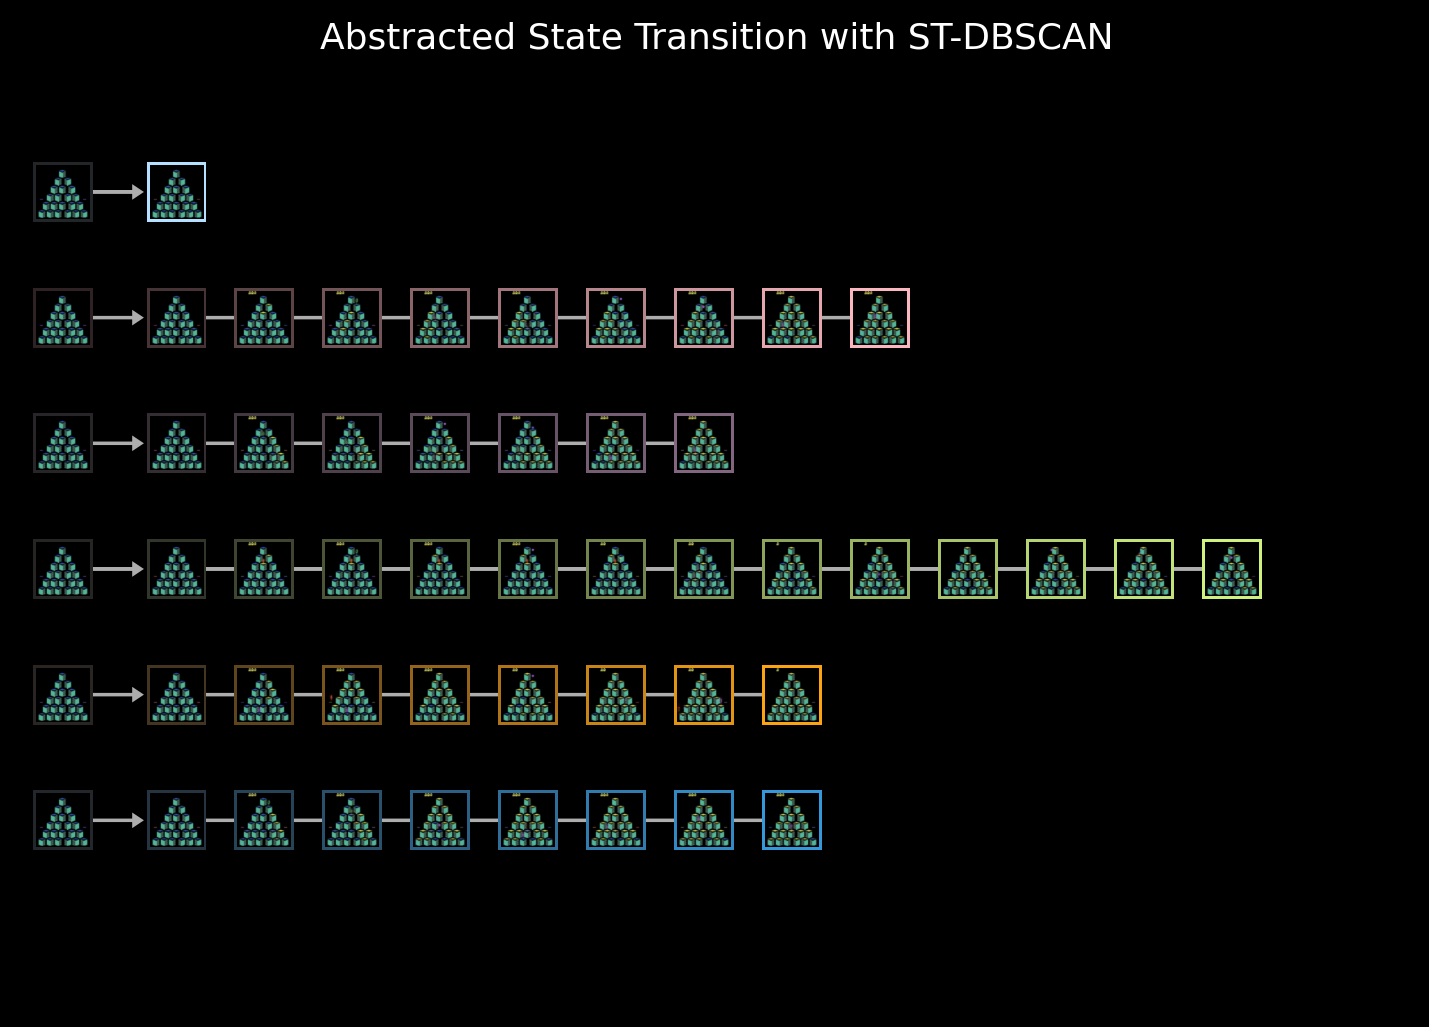

In [36]:
from matplotlib.offsetbox import TextArea
import json

window_size = 2
magnify = 3
fig, ax =plt.subplots(dpi=72*magnify)
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
cluster_labels = np.unique(principalDf["cls"])  
n_clusters = cluster_labels.shape[0] 
dx_coeff = 0.7
concatMinSequence = []

if clustering == 'hdb': 
    title = 'Abstracted State Transition with HDBSCAN'
elif clustering == 'sc': 
   title = 'Abstracted State Transition with Spectral Clustering'
elif clustering == 'hir': 
   title = 'Abstracted State Transition with Agglomerative Clustering'
elif clustering == 'stdb': 
   title = 'Abstracted State Transition with ST-DBSCAN'

ax.set_facecolor('#000000')
ax.tick_params(colors='#adadad')
ax.set_title(title, color='#FFFFFF')
ax.xaxis.label.set_color('#adadad')
ax.yaxis.label.set_color('#adadad')
matrix = []
colors = ['#B4E1FF','#FBB7C0','#82667F','#CFF27E', "#FCA311", "#3498db"]
trajectory = {}

for i in range(len(label_name)):
   min_frame = min_frames[i]
   max_frame = max_frames[i]
   cls_seq = get_cls_sequence(agent_num=i, df=principalDf, min_frame=min_frame, max_frame=max_frame)
   if clustering == 'stdb' or clustering == 'hdb':
      noise_index = np.where(cls_seq == np.min(cls_seq))[0]
      if noise_index.size == cls_seq.size: # if all are the noise, keep the cluster
         noise_index = []
      cls_seq = np.delete(cls_seq,  noise_index)
   max_cls_in_window = get_most_frequent_cls(cls_seq, window_size)
   min_cls_seq = get_minimum_sequence(max_cls_in_window)
   
   
   print('****** ' + label_name[i] + ' ******')
   print(cls_seq)
   print(max_cls_in_window)
   print(min_cls_seq)
   concatMinSequence.append(list(min_cls_seq))
   

   # Save trajectory as json format
   trajectory[str(label_name[i])] = min_cls_seq.tolist()
   

   m = transition_matrix(min_cls_seq, n_clusters)
   #print(m)
   #for row in m: print(' '.join('{0:.2f}'.format(x) for x in row))
   matrix.append(m)
   offsetbox = TextArea(label_name[i], textprops=dict(color='#FFFFFF'))
   dx = -dx_coeff 
   dy = 0.12 - i*0.25
   xy = (dx,  dy)
   ab = AnnotationBbox(offsetbox, xy, frameon=False,
                    xybox=xy,
                    xycoords='data'                    
                    )
   ax.add_artist(ab)

   # Plot initial image
   path = './cls_images/' + game + '/initial.png'
   dx = -0.25 *dx_coeff *2
   dy = 0 - i*0.25 
   xy = (dx,  dy)
   colors = sns.dark_palette(agent_colors[i],  len(min_cls_seq)+1, reverse=False)
   ab = AnnotationBbox(getImage(path, zoom=0.4*dx_coeff ), xy, frameon=True,
                  xybox=(0, 0),
                  xycoords='data',
                  boxcoords="offset points",
                  pad=0.0,
                  bboxprops =dict(edgecolor=colors[0], lw=2))
   ax.add_artist(ab)
   ax.arrow(dx, dy, 0.28, 0, head_width = 0.02, head_length = 0.03, fc ='#adadad', ec ='#adadad')
   
   for j, cls in enumerate(min_cls_seq):
      path = './cls_images/' + game + '/cls_image_' + str(cls) + '_' + clustering + '.png'
      dx = -0.25 + (j+1)*0.5 *dx_coeff 
      dy = 0 - i*0.25
      xy = (dx,  dy)
      #colors = sns.dark_palette(agent_colors[i],  len(min_cls_seq)+1, reverse=False)
      ab = AnnotationBbox(getImage(path, zoom=0.4*dx_coeff ), xy, frameon=True,
                     xybox=(0, 0),
                     xycoords='data',
                     boxcoords="offset points",
                     pad=0.0,
                     bboxprops =dict(edgecolor=colors[j+1], lw=2))
      ax.add_artist(ab)
      if cls != min_cls_seq[-1]:
         ax.arrow(dx, dy, 0.28, 0, head_width = 0.02, head_length = 0.03, fc ='#adadad', ec ='#adadad')
      
fig.set_facecolor('#000000')
ax.set_xlim(-0.5, 5)  
ax.set_ylim(-1.4, 0.25)  
ratio = 0.6
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Save trajectory as json format
with open('./saved_images/' + game + "/trajectory_" + game + ".json", "w") as outfile:
      json.dump(trajectory, outfile)

plt.savefig('./saved_images/' + game + '/ClusterTransition_' + clustering + '_' + vae_type + '.png')


In [43]:
def distance_matrix(nodeList, z_code):
    #n = 1+ max(transitions) #number of states
    n = len(nodesList)
    M = [[0]*n for _ in range(n)]

    for i in range(n):
        for j in range(n):
            z_code1 = z_code[nodeList[i]]
            z_code2 = z_code[nodeList[j]]
            squares = [(p-q) ** 2 for p, q in zip(z_code1, z_code2)]
            M[i][j] = sum(squares) ** .5

    return M

def connectivity_matrix(nodeList, concatMinSequence):
    n = len(nodesList)
    M = [[0]*n for _ in range(n)]

    for i in range(len(concatMinSequence)):
        for j in range(len(concatMinSequence[i])):
            if len(concatMinSequence[i]) == 1:
                M[i][i] += 1
            else:
                if j != len(concatMinSequence[i])-1:
                    src = nodesList.index(concatMinSequence[i][j])
                    tgt = nodesList.index(concatMinSequence[i][j+1])
                    M[src][tgt] += 1
    return M

def group_matrix(nodeList, concatMinSequence):
    n = len(nodesList)
    M = [[-1]*n for _ in range(n)]

    for i in range(len(concatMinSequence)):
        for j in range(len(concatMinSequence[i])):
            if len(concatMinSequence[i]) == 1:
                M[i][i] = i
            else:
                if j != len(concatMinSequence[i])-1:
                    src = nodesList.index(concatMinSequence[i][j])
                    tgt = nodesList.index(concatMinSequence[i][j+1])
                    M[src][tgt] = i
    return M

In [42]:
graph_data={}

# Create nodes data
nodesList=[]
nodesListGroup=[]
agentList=[]
for i in range(len(concatMinSequence)):
    for j in range(len(concatMinSequence[i])):
        nodesList.append(concatMinSequence[i][j])
        nodesListGroup.append(i)
        agentList.append(label_name[i])


distMatrix = distance_matrix(nodesList, z_code_by_cls_np)
conMatrix = connectivity_matrix(nodesList, concatMinSequence)
gpMatrix = group_matrix(nodesList, concatMinSequence)

nodes_items = []

for i in range(len(nodesList)):
    nodes_items.append({'id': int(nodesList[i]), 'group': int(nodesListGroup[i]), 'agent':str(agentList[i])})
graph_data['nodes'] = nodes_items

# Create links data
links_items = []
for i in range(len(nodesList)):
    for j in range(len(nodesList)):
            links_items.append({'source': int(nodesList[i]), 'target': int(nodesList[j]), 'distance':distMatrix[i][j], 'connect':conMatrix[i][j], 'group': gpMatrix[i][j]})
graph_data['links'] = links_items

# Create trajectory data
trajectory_items = []
for i in range(len(concatMinSequence)):
    for j in range(len(concatMinSequence[i])):
            if len(concatMinSequence[i]) != 1:
                if j < len(concatMinSequence[i])-1:
                    trajectory_items.append({'source': int(concatMinSequence[i][j]), 'target': int(concatMinSequence[i][j+1]), 'group': int(i), 'agent':str(label_name[i])})
graph_data['trajectory'] = trajectory_items

# Save graphData as json format
with open('./saved_images/' + game + "/graphData_" + game + ".json", "w") as outfile:
    json.dump(graph_data, outfile)





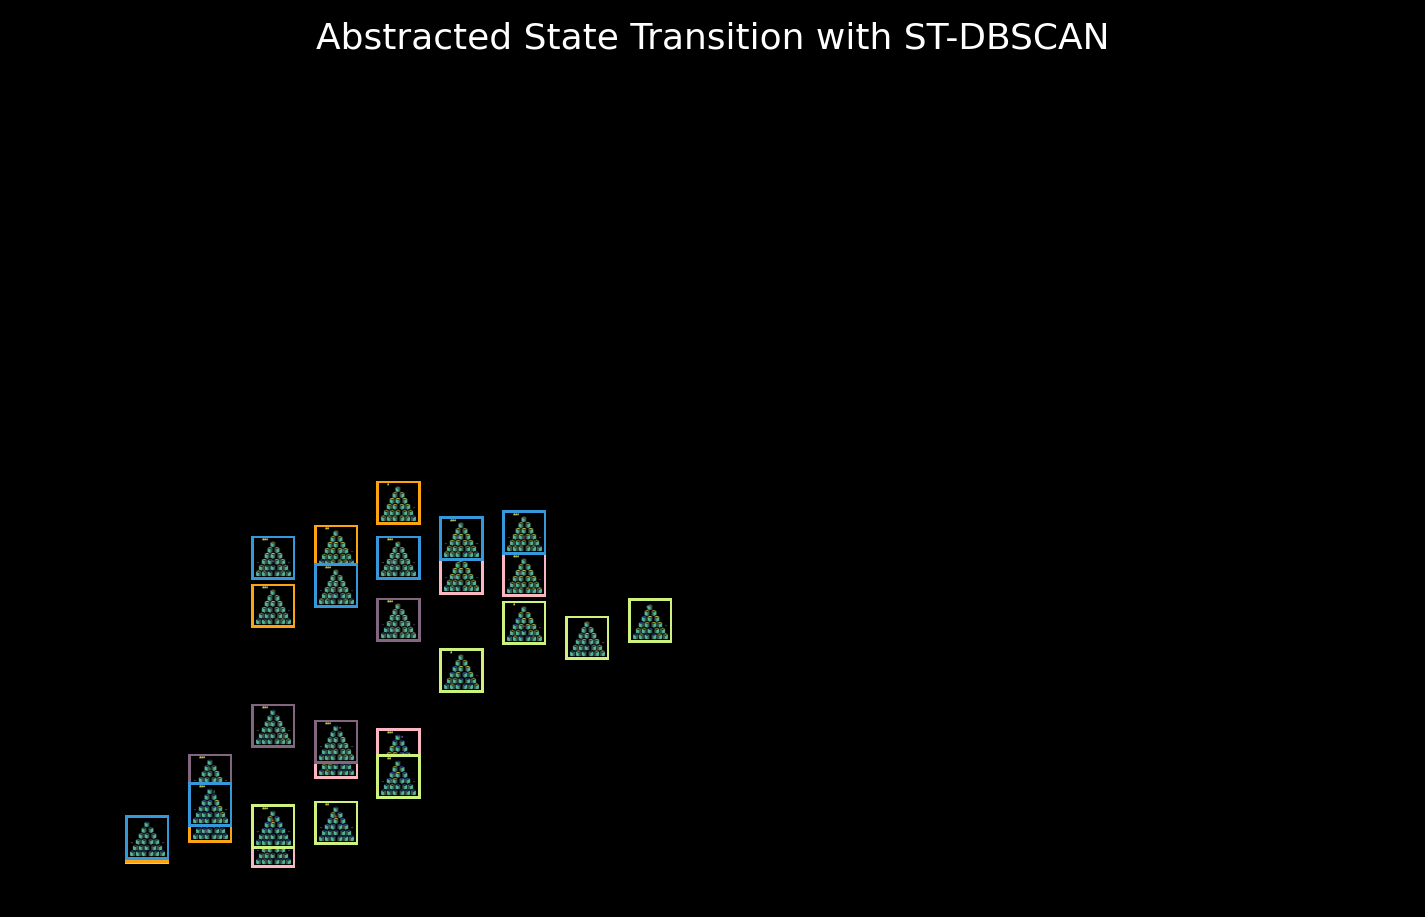

In [ ]:
window_size = 30
magnify = 3
fig, ax =plt.subplots(dpi=72*magnify)
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

ax.set_facecolor('#000000')
ax.tick_params(colors='#adadad')
ax.set_title(title, color='#FFFFFF')
ax.xaxis.label.set_color('#adadad')
ax.yaxis.label.set_color('#adadad')
colors = ['#B4E1FF','#FBB7C0','#82667F','#CFF27E', "#FCA311", "#3498db"]

for i in range(len(label_name)):
   min_frame = min_frames[i]
   max_frame = max_frames[i]
   cls_seq = get_cls_sequence(agent_num=i, df=principalDf, min_frame=min_frame, max_frame=max_frame)
   if clustering == 'stdb' or clustering == 'hdb':
      noise_index = np.where(cls_seq == np.min(cls_seq))[0]
      if noise_index.size == cls_seq.size: # if all are the noise, keep the cluster
         noise_index = []
      cls_seq = np.delete(cls_seq,  noise_index)
   max_cls_in_window = get_most_frequent_cls(cls_seq, window_size)
   min_cls_seq = get_minimum_sequence(max_cls_in_window)
   #colors = sns.dark_palette(agent_colors[i],  len(min_cls_seq)+1, reverse=False)
   for j, cls in enumerate(min_cls_seq):
      path = './cls_images/' + game + '/cls_image_' + str(cls) + '_' + clustering + '.png'
      dx = -0.25 + (j+1)*0.25 
      dy = imageAxis[cls] * 1
      xy = (dx,  dy)
      #colors = sns.dark_palette(agent_colors[i],  len(min_cls_seq)+1, reverse=False)
      ab = AnnotationBbox(getImage(path, zoom=0.2), xy, frameon=True,
                     xybox=(0, 0),
                     xycoords='data',
                     boxcoords="offset points",
                     pad=0.0,
                     bboxprops =dict(edgecolor=colors[i], lw=2))
      ax.add_artist(ab)

fig.set_facecolor('#000000')
ax.set_xlim(-0.5, 5)  
ax.set_ylim(-1.5, 1.5)  
ratio = 0.6
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

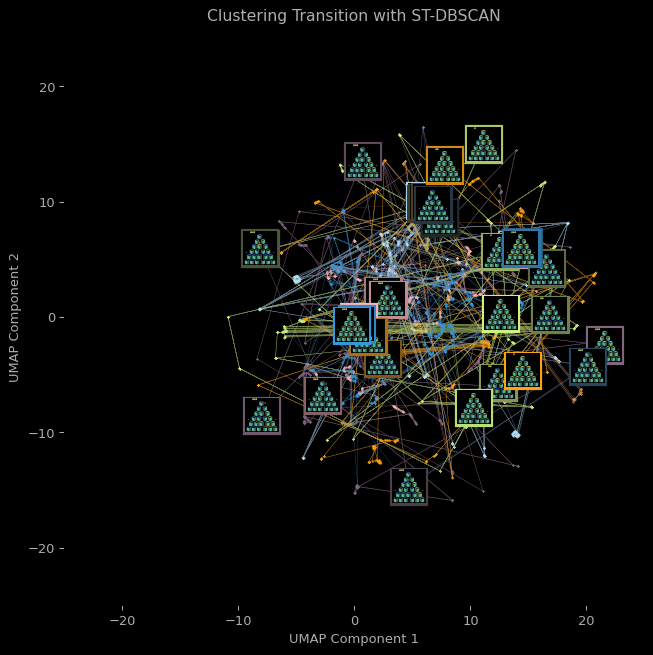

In [ ]:
magnify = 1.3
fig, ax =plt.subplots(dpi=72*magnify, figsize=(8,8))
cluster_labels = np.unique(principalDf["cls"])  
n_clusters = cluster_labels.shape[0]    
count = 0 
agent_id = 0

agent_colors = ['#B4E1FF','#FBB7C0','#82667F','#CFF27E', "#FCA311", "#3498db"]
ax.set_facecolor('#000000')
ax.tick_params(colors='#adadad')
if clustering == 'hdb': 
    title = 'Clustering Transition with HDBSCAN'
elif clustering == 'sc': 
   title = 'Clustering Transition with Spectral Clustering'
elif clustering == 'hir': 
   title = 'Clustering Transition with Agglomerative Clustering'
elif clustering == 'stdb': 
   title = 'Clustering Transition with ST-DBSCAN'

ax.set_title(title, color='#adadad')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.xaxis.label.set_color('#adadad')
ax.yaxis.label.set_color('#adadad')

colors = ['#B4E1FF','#FBB7C0','#82667F','#CFF27E', "#FCA311", "#3498db"]
for idx, color in enumerate(colors):
   filter = principalDf["label"] == idx
   plotdata=principalDf.where(filter).sort_values(by=['frame'])
   #ax.scatter(x=plotdata["component1"], y=plotdata["component2"],
   #   c=color, label=label_name[idx], alpha=0.1, marker='.',  s = 5)
   ax.plot(plotdata["component1"], plotdata["component2"],
      c=color, label=label_name[idx], alpha=0.5, marker='.', ls='-', linewidth=0.3, markersize=0.5)

for i in range(len(label_name)):
   min_frame = min_frames[i]
   max_frame = max_frames[i]
   cls_seq = get_cls_sequence(agent_num=i, df=principalDf, min_frame=min_frame, max_frame=max_frame)
   if clustering == 'stdb' or clustering == 'hdb':
      noise_index = np.where(cls_seq == np.min(cls_seq))[0]
      if noise_index.size == cls_seq.size: # if all are the noise, keep the cluster
         noise_index = []
      cls_seq = np.delete(cls_seq,  noise_index)
   max_cls_in_window = get_most_frequent_cls(cls_seq, window_size)
   min_cls_seq = get_minimum_sequence(max_cls_in_window)

   colors = sns.dark_palette(agent_colors[i],  len(min_cls_seq)+1, reverse=False)

   path = './cls_images/' + game + '/initial.png'
   xy = (z_initial_pca[0][0],  z_initial_pca[0][1])
   
   ab = AnnotationBbox(getImage(path, zoom=0.4), xy, frameon=True,
                  xybox=(0, 0),
                  xycoords='data',
                  boxcoords="offset points",
                  pad=0.0,
                  bboxprops =dict(edgecolor=colors[0], lw=4))
      

   ax.add_artist(ab)

   for j, cls in enumerate(min_cls_seq):
      path = './cls_images/' + game + '/cls_image_' + str(cls) + '_' + clustering + '.png'
      xy = (z_cls_pca[cls][0],  z_cls_pca[cls][1])
      
      ab = AnnotationBbox(getImage(path, zoom=0.4), xy, frameon=True,
                     xybox=(0, 0),
                     xycoords='data',
                     boxcoords="offset points",
                     pad=0.0,
                     bboxprops =dict(edgecolor=colors[j+1], lw=4))
         

      ax.add_artist(ab)
fig.set_facecolor('#000000')
#offset=20
#ratio=1
#ax.set_xlim(np.min(z_cls_pca[:][0])-offset, np.max(z_cls_pca[:][0])+offset)  
#ax.set_ylim(np.min(z_cls_pca[:][1])-offset, np.max(z_cls_pca[:][1])+offset)   
ax.set_xlim(-25, 25)  
ax.set_ylim(-25, 25)   
#x_left, x_right = ax.get_xlim()
#y_low, y_high = ax.get_ylim()
#ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
#ax.legend(facecolor='#000000', labelcolor='#adadad', bbox_to_anchor=(1.45,1.02))

plt.savefig('./saved_images/' + game + '/ClusterTransition_in_latent_' + clustering + '_' + vae_type + '.png')

In [ ]:
from datashader.bundling import hammer_bundle

colors = ['#B4E1FF','#FBB7C0','#82667F','#CFF27E', "#FCA311", "#3498db"]
ds_nodes_py = []
ds_edges_py = []
for idx, color in enumerate(colors):
    filter = principalDf["label"] == idx
    sorted_data = principalDf.where(filter).sort_values(by=['frame'])
    sorted_data = sorted_data[~np.isnan(sorted_data['frame'])]
    prev_node = 0
    for ind in sorted_data.index:
        ds_nodes_py.append([ind, sorted_data['component1'][ind], sorted_data['component2'][ind], int(idx)]) 
        if int(sorted_data['frame'][ind]) != 0:
            ds_edges_py.append([prev_node, ind, int(idx)])
            
        prev_node = ind

ds_nodes = pd.DataFrame(ds_nodes_py, columns=['name', 'x', 'y', 'label'])      
ds_edges = pd.DataFrame(ds_edges_py, columns=['source', 'target', 'label'])



#nx.draw_networkx_nodes(graph, pos=pos, node_color=c_iris[nodes], ax=ax, node_size=50, edgecolors='white', linewidths=1)
#nx.draw_networkx_edges(graph, pos=pos, width=weights, alpha=0.1618, ax=ax)
    #ax.plot(plotdata["component1"], plotdata["component2"],
    #  c=color, label=label_name[idx], alpha=0.5, marker='.', ls='-', linewidth=0.3, markersize=0.5)

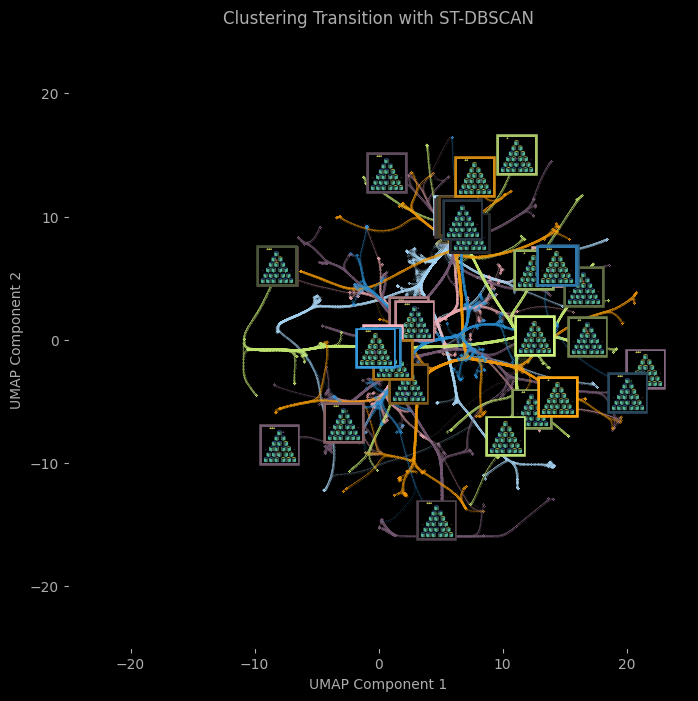

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('#000000')
ax.tick_params(colors='#adadad')
ax.set_title(title, color='#adadad')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.xaxis.label.set_color('#adadad')
ax.yaxis.label.set_color('#adadad')


for idx, color in enumerate(colors):
    filter = ds_edges["label"] == idx
    ds_edges_label = ds_edges.where(filter)[['source', 'target']]
    ds_edges_label = ds_edges_label[~np.isnan(ds_edges_label['source'])]
    filter = ds_nodes["label"] == idx
    ds_nodes_label = ds_nodes.where(filter)[['name', 'x', 'y']]
    ds_nodes_label = ds_nodes_label[~np.isnan(ds_nodes_label['x'])]
    #print(ds_nodes_label)
    #print(ds_edges_label)
    hb = hammer_bundle(ds_nodes_label, ds_edges_label, iterations=5, decay=0.5, initial_bandwidth=1.0)
    ax.plot(hb.x, hb.y, c=color, zorder=1, alpha=0.4, marker='.', ls='-', linewidth=0.1, markersize=0.2)


data_clustered = []
node_id = 0
for i in range(len(label_name)):
   min_frame = min_frames[i]
   max_frame = max_frames[i]
   cls_seq = get_cls_sequence(agent_num=i, df=principalDf, min_frame=min_frame, max_frame=max_frame)
   if clustering == 'stdb' or clustering == 'hdb':
      noise_index = np.where(cls_seq == np.min(cls_seq))[0]
      if noise_index.size == cls_seq.size: # if all are the noise, keep the cluster
         noise_index = []
      cls_seq = np.delete(cls_seq,  noise_index)
   max_cls_in_window = get_most_frequent_cls(cls_seq, window_size)
   min_cls_seq = get_minimum_sequence(max_cls_in_window)

   colors = sns.dark_palette(agent_colors[i],  len(min_cls_seq)+1, reverse=False)

   path = './cls_images/' + game + '/initial.png'
   xy = (z_initial_pca[0][0],  z_initial_pca[0][1])
   data_clustered.append([z_initial_pca[0][0],  z_initial_pca[0][1], path, -1, -1, -1]) # x, y, path, agent id, node_id, source
   ab = AnnotationBbox(getImage(path, zoom=0.4), xy, frameon=True,
                  xybox=(0, 0),
                  xycoords='data',
                  boxcoords="offset points",
                  pad=0.0,
                  bboxprops =dict(edgecolor=colors[0], lw=4))
      

   ax.add_artist(ab)

   for j, cls in enumerate(min_cls_seq):
      path = './cls_images/' + game + '/cls_image_' + str(cls) + '_' + clustering + '.png'
      xy = (z_cls_pca[cls][0],  z_cls_pca[cls][1])

      # Create Graph Object
      if j==0:
         data_clustered.append([z_cls_pca[cls][0],  z_cls_pca[cls][1], path, i, node_id, -1]) # x, y, path, agent id, node_id, source
      else:
         data_clustered.append([z_cls_pca[cls][0],  z_cls_pca[cls][1], path, i, node_id, prev_node])

      prev_node=node_id
      node_id += 1
         
      ab = AnnotationBbox(getImage(path, zoom=0.4), xy, frameon=True,
                     xybox=(0, 0),
                     xycoords='data',
                     boxcoords="offset points",
                     pad=0.0,
                     bboxprops =dict(edgecolor=colors[j+1], lw=4))
         

      ax.add_artist(ab)

df_clustered = pd.DataFrame(data_clustered, columns=['x', 'y', 'path', 'agent id', 'node_id', 'source']) 

fig.set_facecolor('#000000')
ax.set_xlim(-25, 25)  
ax.set_ylim(-25, 25) 
plt.savefig('./saved_images/' + game + '/ClusterTransition_in_latent_bundle_' + clustering + '_' + vae_type + '.png')

In [ ]:
column_name=list(df_clustered.columns) + ['high_cls']

hir_clus_model = AgglomerativeClustering(n_clusters = 10, affinity = 'euclidean', linkage = 'ward').fit(df_clustered[['x','y']].to_numpy())
cls = pd.DataFrame(list(hir_clus_model.labels_))

df_clustered = pd.concat([df_clustered,cls],axis = 1,join='inner', ignore_index=True)
df_clustered = df_clustered.loc[:,~df_clustered.columns.duplicated()]
df_clustered.columns = column_name
df_clustered.head(50)

c:\Users\shira\anaconda3\envs\XAI\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


,x,y,path,agent id,node_id,source,high_cls
0,7.363326,8.629033,./cls_images/qbert/initial.png,-1,-1,-1,3
1,6.071569,10.086443,./cls_images/qbert/cls_image_1_stdb.png,0,0,-1,3
2,7.363326,8.629033,./cls_images/qbert/initial.png,-1,-1,-1,3
3,6.182191,9.846121,./cls_images/qbert/cls_image_51_stdb.png,1,1,-1,3
4,-8.112036,5.926049,./cls_images/qbert/cls_image_86_stdb.png,1,2,1,5
5,-2.765712,-6.781350,./cls_images/qbert/cls_image_91_stdb.png,1,3,2,4
6,2.476733,1.838985,./cls_images/qbert/cls_image_98_stdb.png,1,4,3,1
7,2.910581,1.537721,./cls_images/qbert/cls_image_55_stdb.png,1,5,4,1
8,13.972157,5.880412,./cls_images/qbert/cls_image_73_stdb.png,1,6,5,0
9,0.351212,-0.440240,./cls_images/qbert/cls_image_77_stdb.png,1,7,6,1


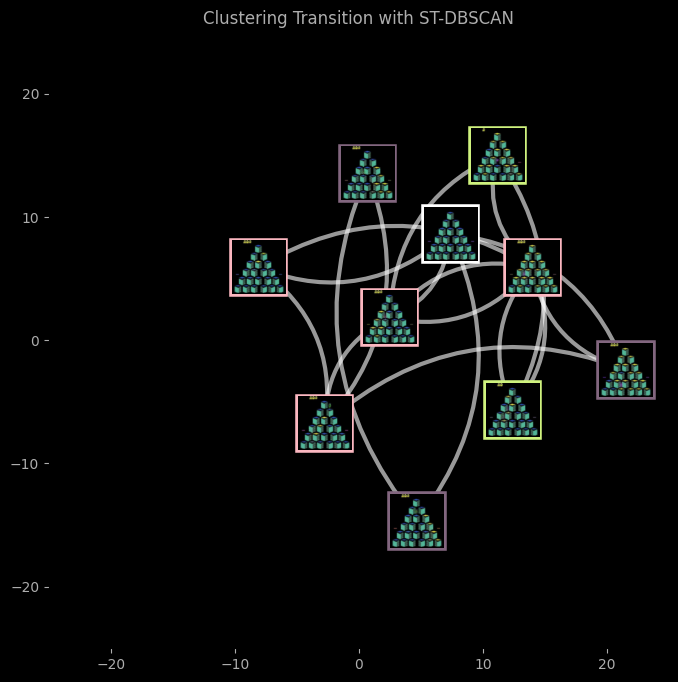

In [ ]:
import networkx as nx

G = nx.DiGraph()
cluster_labels = np.unique(df_clustered["high_cls"]) 
for h_cls in cluster_labels:
    pos_x = list(df_clustered[df_clustered["high_cls"]==h_cls]['x'])
    pos_y = list(df_clustered[df_clustered["high_cls"]==h_cls]['y'])
    path = list(df_clustered[df_clustered["high_cls"]==h_cls]['path'])
    agent_id = list(df_clustered[df_clustered["high_cls"]==h_cls]['agent id'])
    G.add_node(h_cls, pos=(pos_x[0], pos_y[0]), path=path[0], agent_id = agent_id[0])
    #print(list(df_clustered[df_clustered["high_cls"]==h_cls]['source']))
    for source in list(df_clustered[df_clustered["high_cls"]==h_cls]['source']):
        #print(source)
        for source_cls in list(df_clustered[df_clustered["node_id"] == source]['high_cls']):
            #print('source: ' + str(source_cls)+ ' target: '+ str(h_cls))
            if source_cls != h_cls: G.add_edge(source_cls, h_cls)

colors = ['#B4E1FF','#FBB7C0','#82667F','#CFF27E', "#FCA311", "#3498db"]
fig, ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('#000000')
ax.tick_params(colors='#adadad')
ax.set_title(title, color='#adadad')
ax.xaxis.label.set_color('#adadad')
ax.yaxis.label.set_color('#adadad')

pos = nx.get_node_attributes(G, 'pos')
path = nx.get_node_attributes(G, 'path')
agent_id = nx.get_node_attributes(G, 'agent_id')

for edge in G.edges():
    source, target = edge
    rad = -0.3
    
    arrowprops=dict(arrowstyle="->", 
                    color='w',
                    connectionstyle=f"arc3,rad={rad}",
                    linestyle= '-',
                    alpha=0.6,
                    linewidth=3,
                    )
    ax.annotate("",
                xy=pos[target],
                xytext=pos[source],
                arrowprops=arrowprops,
               )
    



for i, p in path.items():
    xy=pos[i]
    if agent_id[i]==-1:
        edgecolor='w'
    else:
        edgecolor=colors[agent_id[i]]
    ab = AnnotationBbox(getImage(p, zoom=0.6), xy, frameon=True,
                     xybox=(0, 0),
                     xycoords='data',
                     boxcoords="offset points",
                     pad=0.0,
                     bboxprops =dict(edgecolor=edgecolor, lw=4))
         

    ax.add_artist(ab)

#nx.draw_networkx_nodes(G,pos)

fig.set_facecolor('#000000')
ax.set_xlim(-25, 25)  
ax.set_ylim(-25, 25) 
    #print(df_clustered[df_clustered["node_id"] == df_clustered[df_clustered["high_cls"]==h_cls]['source']]["high_cls"])
#G.add_node(id,pos=(x,y))
plt.savefig('./saved_images/' + game + '/ClusterTransition_in_latent_simple_' + clustering + '_' + vae_type + '.png')
